In [44]:
# import the important libraries
import rasterio
import os
from rasterio import plot
from rasterio.mask import mask
from rasterio.merge import merge
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np 
import geopandas as gpd
import geojson
%matplotlib inline

### เลือก Dataset ใน SMAP ที่สอดคล้องกับ Soil Hydrulic ที่สามารถมาเทียบได้
### Soil Wetness (SM_surface_wetness) เพื่อดูพื้นที่เสี่ยงต่อการเกิดภัยเเล้ง ซึ่งมีค่าระหว่าง 0 ถึง 1 

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3856, 'height': 1822, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.09336099345760829, 0.0, -180.0,
       0.0, -0.09336099345760829, 85.044563293)}
[[-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 ...
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]]


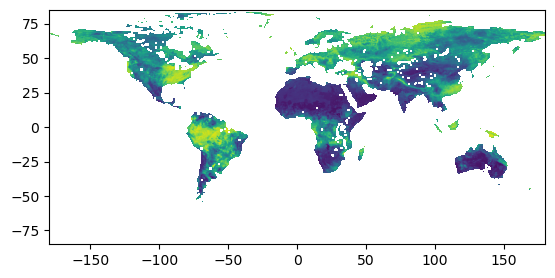

In [34]:
# import relavent dataset from SMAP 4 
# sm_surface_wetness  
# definition 
# Top layer soil wetness (0-5 cm;wetness units). 
# Soil wetness units (dimensionless) vary between 0 and 1, 
# indicating relative saturation between completely dry conditions and 
# completely saturated conditions, respectively.

with rasterio.open('SMAP_L4_SM_gph_20190315T103000_Vv7032_001_Geophysical_Data_sm_surface_wetness_d01dd5d7.tif') as soil_moisture:
    print(soil_moisture.meta)
    nodata_value = soil_moisture.nodata


    
    #masked_soil = np.ma.masked_equal(soil_moisture, nodata_value)
    #print(masked_soil.read(1))
    print(soil_moisture.read(1))
    plot.show(soil_moisture)




<Axes: >

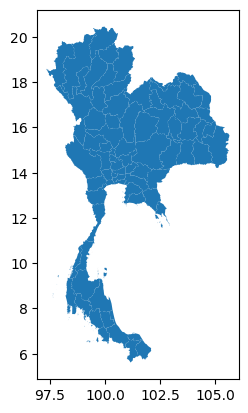

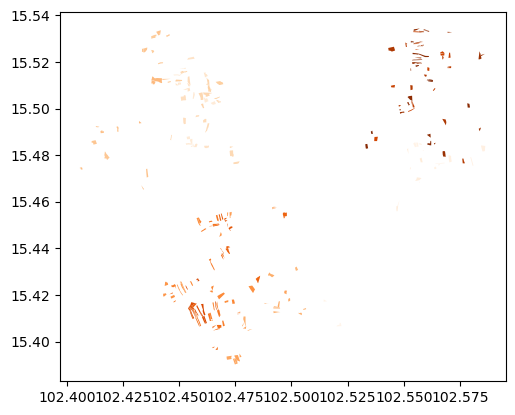

In [114]:
# masked by Nakorn Ratchasima and import rice field  
with open("NAKHON RATCHASIMA_L1_2021_delgeom.geojson") as field:
    rice_field = geojson.load(field)

Nakorn_rice_field = gpd.read_file(rice_field)
Thailand_mask = gpd.read_file('D:\\Users\\Supanut\\ข้อมูลGIS\\ขอบเขตจังหวัดประเทศไทย ทั้ง 77 จังหวัด\\Province_WGS84.shp')

NKR_province = gpd.read_file('Nakhon_rat_bound.shp')

Thailand_wgs84 = Thailand_mask.to_crs(soil_moisture.crs)
NKR_rice_field_wgs = Nakorn_rice_field.to_crs(soil_moisture.crs)


Thailand_wgs84.plot()
NKR_rice_field_wgs.plot(cmap = 'Oranges')




In [64]:
# ทำการเอาขอบเขตประเทศไทยมาตัดกับข้อมูล SMAP

#mask by thailand
# Convert the polygon to a GeoJSON-like format
shape = [mapping(geom) for geom in Thailand_wgs84.geometry]

with rasterio.open('SMAP_L4_SM_gph_20190315T103000_Vv7032_001_Geophysical_Data_sm_surface_wetness_d01dd5d7.tif') as Smap_thailand:
    out_image, out_transform = mask(Smap_thailand, shape, crop=True)
    out_meta = Smap_thailand.meta

# Update metadata
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Save the clipped raster
with rasterio.open('SMAP_thailand.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 90, 'height': 160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.09336099345760829, 0.0, 97.28215056909664,
       0.0, -0.09336099345760829, 20.53211681379267), 'blockysize': 22, 'tiled': False, 'interleave': 'band'}


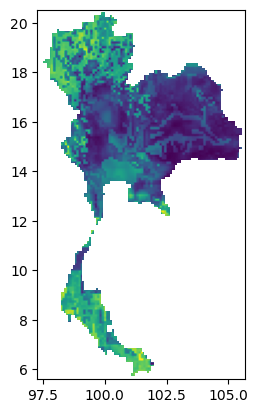

In [88]:
with rasterio.open('SMAP_thailand.tif') as Smap_thai:
    print(Smap_thai.profile)
    plot.show(Smap_thai)


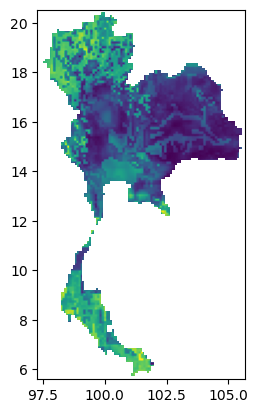

In [136]:
import rasterio.plot
with rasterio.open('SMAP_thailand.tif') as Smap:
    raster_data = Smap.read(1)
    raster_transform = Smap.transform
    raster_crs = Smap.crs
    plot.show(Smap)



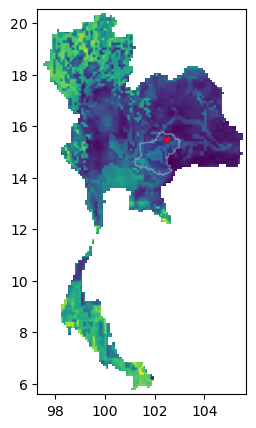

In [135]:
with rasterio.open('SMAP_thailand.tif') as Smap:
    fig, ax = plt.subplots(figsize=(5, 5))
    rasterio.plot.show(Smap, transform=raster_transform, ax=ax, cmap='viridis')
    NKR_province.plot(ax=ax, alpha = 0.3, edgecolor = 'white' )
    NKR_rice_field_wgs.plot(ax=ax, edgecolor='red')



In [137]:
# ทำการเอาขอบเขตจังหวัดนครราชสีมามาตัดกับข้อมูล SMAP

#mask by Nakhon Ratchasima
# Convert the polygon to a GeoJSON-like format
shape_NKR = [mapping(geom) for geom in NKR_province.geometry]

with rasterio.open('SMAP_L4_SM_gph_20190315T103000_Vv7032_001_Geophysical_Data_sm_surface_wetness_d01dd5d7.tif') as Smap_NKR:
    out_image, out_transform = mask(Smap_NKR, shape_NKR, crop=True)
    out_meta = Smap_NKR.meta

# Update metadata
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Save the clipped raster
with rasterio.open('SMAP_NKR.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

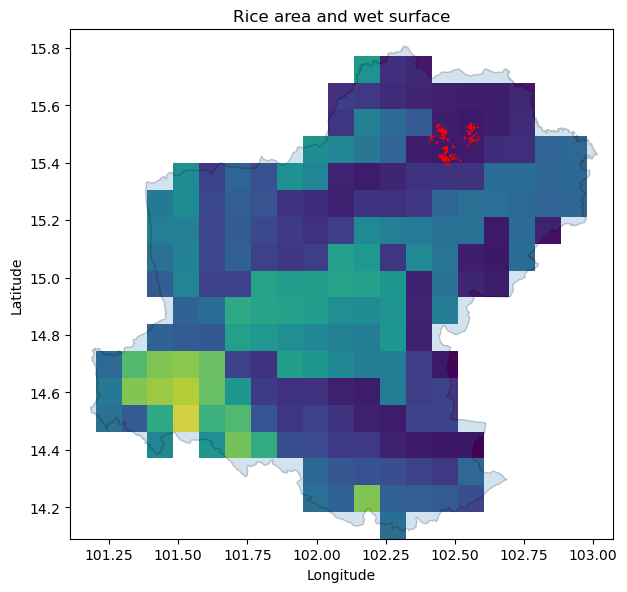

In [146]:
with rasterio.open('SMAP_NKR.tif', 'r') as SMAP_NKR:
    fig, ax = plt.subplots(figsize=(7, 7))
    rasterio.plot.show(SMAP_NKR, transform=SMAP_NKR.transform, ax=ax, cmap='viridis')
    NKR_province.plot(ax=ax, alpha = 0.2, edgecolor = 'black' )
    NKR_rice_field_wgs.plot(ax=ax, edgecolor='red')
    plt.title('Rice area and wet surface')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

จากเเผนที่เเสดงความชื้นบนผิวดินพบว่า พื้นที่เเปลงนาที่ได้รับมาส่วนใหญ่ อยู่ในช่วงความชื้นที่ 0.09 ซึ่งถือว่าต่ำมากซึ่งเสี่ยงต่อการเกิดพื้นที่เเล้ง เเละบางเเปลง ที่ 104 มีค่าอยู่ที่ 0.185 ถือว่ามีความชื้นสูงกว่าหลายเเปลงเเต่ก็ยังมีความชื้นต่ำอยู่เช่นกัน 
ปล. ดูค่าความชื้นโดยการเปิดผ่านโปรเเกรม QGIS เนื่องจาก library io เกิดปัญหาในการอ่านค่า band value จากการทำ process จึงต้องเปิดผ่านโปรเเกรมซอฟเเวร์